## **Catégorisez automatiquement des questions**

### partie 4/8 : Prédiction de tags, approche supervisée + tracking mlflow

#### <br> Notebook d’exploration et de pré-traitement des questions, comprenant une analyse univariée et multivariée, un nettoyage des questions, un feature engineering de type bag of words avec réduction de dimension (du vocabulaire et des tags) 

<br>


## 1 Import


### 1.1 Librairies


In [25]:
# finir d'organiser, check inutiles ?

#
import os, sys, random
import ast
import numpy as np
import pandas as pd
from typing import Tuple
from pandarallel import pandarallel
from pprint import pprint
from collections import Counter

# Visualisation
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image

# NLP
from bs4 import BeautifulSoup
import re, string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# gensim
from gensim import corpora
from gensim.corpora import Dictionary
from gensim.matutils import corpus2dense
from gensim.matutils import Sparse2Corpus
from gensim.models import LdaModel, CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from gensim import similarities
from gensim.models.ldamulticore import LdaMulticore

# sklearn
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.metrics import make_scorer, PredictionErrorDisplay, r2_score
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

from tensorflow import keras
from tensorflow.keras import layers

print('\nPython version ' + sys.version)
print('pyLDAvis version ' + pyLDAvis.__version__)

# Modify if necessary
num_cores = os.cpu_count()
print(f"\nNumber of CPU cores: {num_cores}")
pandarallel.initialize(progress_bar=False, nb_workers=6)

#
import mlflow
from mlflow import MlflowClient
from mlflow.models.signature import infer_signature, ModelSignature #, Schema, ParamSchema
from mlflow.types import Schema, ParamSchema, ParamSpec, ColSpec

# os.environ['MLFLOW_TRACKING_URI'] = './'

# ! REQUIRES CONSOLE COMMAND : mlflow ui
# depuis dossier notebooks

# Utilisable seulement en local...
mlflow.set_tracking_uri("http://localhost:5000")
client = MlflowClient(tracking_uri="http://127.0.0.1:5000")



Python version 3.11.5 (main, Sep 11 2023, 13:23:44) [GCC 11.2.0]
pyLDAvis version 3.4.0

Number of CPU cores: 8
INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ubuntu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ubuntu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### 1.2 Functions


In [26]:
def get_missing_values(df):
    """Generates a DataFrame containing the count and proportion of missing values for each feature.

    Args:
        df (pandas.DataFrame): The input DataFrame to analyze.

    Returns:
        pandas.DataFrame: A DataFrame with columns for the feature name, count of missing values,
        count of non-missing values, proportion of missing values, and data type for each feature.
    """
    # Count the missing values for each column
    missing = df.isna().sum()

    # Calculate the percentage of missing values
    percent_missing = df.isna().mean() * 100

    # Create a DataFrame to store the results
    missings_df = pd.DataFrame({
        'column_name': df.columns,
        'missing': missing,
        'present': df.shape[0] - missing,  # Count of non-missing values
        'percent_missing': percent_missing.round(2),  # Rounded to 2 decimal places
        'type': df.dtypes
    })

    # Sort the DataFrame by the count of missing values
    missings_df.sort_values('missing', inplace=True)

    return missings_df

# with pd.option_context('display.max_rows', 1000):
#   display(get_missing_values(df))


def quick_look(df, miss=True):
    """
    Display a quick overview of a DataFrame, including shape, head, tail, unique values, and duplicates.

    Args:
        df (pandas.DataFrame): The input DataFrame to inspect.
        check_missing (bool, optional): Whether to check and display missing values (default is True).

    The function provides a summary of the DataFrame, including its shape, the first and last rows, the count of unique values per column, and the number of duplicates.
    If `check_missing` is set to True, it also displays missing value information.
    """
    print(f'shape : {df.shape}')

    display(df.head())
    display(df.tail())

    print('uniques :')
    display(df.nunique())

    print('Doublons ? ', df.duplicated(keep='first').sum(), '\n')

    if miss:
        display(get_missing_values(df))


def preprocess_text(text):
    #Cleaning
    text = BeautifulSoup(text, 'html.parser').get_text()
    text = text.lower().strip()

    # Tokenization
    try:
        tokens = nltk.word_tokenize(text)
        tokenizer = nltk.RegexpTokenizer(r'\w+')
        tokens = tokenizer.tokenize(" ".join(tokens))  # Apply RegexpTokenizer to the entire list

        # Remove punctuation (make sure, RegexpTokenizer should have done it already)
        tokens = [token for token in tokens if token not in string.punctuation]

    except Exception as e:
        print(f"Error in tokenization: {e}")
        return []

    # Lemmatization
    lemmatizer = WordNetLemmatizer()

    # Get part of speech for each token
    pos_tags = nltk.pos_tag(tokens)
    lemmatized_tokens = []

    for token, pos_tag in pos_tags:
        # ! Uncommenting next line may crash the cell
        # print(f"Token: {token}, POS Tag: {pos_tag}")
        if pos_tag.startswith('V'):
            # On garde
            lemmatized_tokens.append(lemmatizer.lemmatize(token, pos='v'))
            # Returns the input word unchanged if it cannot be found in WordNet.
        elif pos_tag.startswith('N'):
            # On garde
            try:
                lemmatized_tokens.append(lemmatizer.lemmatize(token, pos='n'))
            except Exception as e:
                print(f"Error lemmatizing verb {token}: {e}")
        # Sinon on supprime

    # Read forbidden words (stopwords, too frequent, too rare) from the file
    with open('./forbidden_words.txt', 'r') as file:
        forbidden = [line.strip() for line in file]

    filtered_list = [token for token in lemmatized_tokens if token not in forbidden]

    # keep uniques
    seen_tokens = set()
    unique_tokens = []

    for token in filtered_list:
        if token not in seen_tokens:
            seen_tokens.add(token)
            if len(token) > 2:
                unique_tokens.append(token)

    return unique_tokens


In [27]:
def create_mlflow_experiment(
    experiment_name: str, artifact_location: str, tags: dict[str, str]
) -> str:
    """
    Create a new mlflow experiment with the given name and artifact location.

    Parameters:
    ----------
    experiment_name: str
        The name of the experiment to create.
    artifact_location: str
        The artifact location of the experiment to create.
    tags: dict[str,Any]
        The tags of the experiment to create.

    Returns:
    -------
    experiment_id: str
        The id of the created experiment.
    """
    try:
        experiment_id = mlflow.create_experiment(
            name=experiment_name, artifact_location=artifact_location, tags=tags
        )
    except:
        print(f"Experiment {experiment_name} already exists.")
        experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id

    mlflow.set_experiment(experiment_name=experiment_name)

    return experiment_id


def get_mlflow_experiment(
    experiment_id: str = None, experiment_name: str = None
) -> mlflow.entities.Experiment:
    """
    Retrieve the mlflow experiment with the given id or name.

    Parameters:
    ----------
    experiment_id: str
        The id of the experiment to retrieve.
    experiment_name: str
        The name of the experiment to retrieve.

    Returns:
    -------
    experiment: mlflow.entities.Experiment
        The mlflow experiment with the given id or name.
    """
    if experiment_id is not None:
        experiment = mlflow.get_experiment(experiment_id)
    elif experiment_name is not None:
        experiment = mlflow.get_experiment_by_name(experiment_name)
    else:
        raise ValueError("Either experiment_id or experiment_name must be provided.")

    return experiment


def turn_str_back_into_list(df):
    """Correct the type change due to .csv export"""

    df['title_nltk'] = df['title_nltk'].apply(ast.literal_eval)
    df['body_nltk'] = df['body_nltk'].apply(ast.literal_eval)
    df['title_spacy'] = df['title_spacy'].apply(ast.literal_eval)
    df['body_spacy'] = df['body_spacy'].apply(ast.literal_eval)
    df['all_tags'] = df['all_tags'].apply(ast.literal_eval)



In [28]:
# Again, this needs mlfow ui console command first -> unusable on remote server
# all_experiments = client.search_experiments()
# pprint(all_experiments)


### 1.3 Data


In [29]:
raw_data = pd.read_csv('./../0_data/cleaned_data/bow_classic.csv', sep=',')

turn_str_back_into_list(raw_data)

display(raw_data.tail())

print(raw_data.shape)


,CreationDate,title,body,all_tags,title_nltk,body_nltk,title_spacy,body_spacy
47660,2011-05-23 22:22:56,How can I send a file document to the printer ...,Here's the basic premise:\nMy user clicks some...,"[c#, winforms, pdf, .net-4.0, printing]","[send, file, document, printer, print]","[send, file, document, printer, print, premise...","[send, file, document, printer, print]","[premise, user, click, file, spit, desktop, wa..."
47661,2011-05-23 21:15:51,CA1014 Mark 'some.dll' with CLSCompliant(true)...,"When I run StyleCop, I got this error message ...","[visual-studio, visual-studio-2010, dll, style...","[mark, dll, error, message, vs2010]","[mark, dll, error, message, vs2010, run, get, ...","[error, message]","[run, error, message, need, mark, dll, set, dl..."
47662,2011-05-23 21:05:59,How to change a text file's name in C++?,"I would like to change a txt file's name, but ...","[c++, algorithm, file, directory, file-rename]","[change, text, file, name, c]","[change, text, file, name, c, like, change, tx...","[change, text, file]","[like, change, txt, file, find, example, want,..."
47663,2011-05-23 20:06:35,php implode (101) with quotes,Imploding a simple array \nwould look like th...,"[php, arrays, string, csv, implode]","[php, quote]","[php, quote, array, look, array, array, lastna...",[quote],"[implode, array, look, array, email, phone, ar..."
47664,2011-05-23 20:00:57,What characters are allowed in a iOS file name?,I'm looking for a way to make sure a string ca...,"[ios, file, filenames, character-encoding, nsf...","[character, allow, file, name]","[character, allow, file, name, look, way, make...","[character, allow, file]","[look, way, string, file, section, code, delet..."


(47665, 8)


In [30]:
# pour parcourir rapidement la premiere partie du ntbk
quick_df = raw_data[::100]

train_df, test_df = train_test_split(quick_df, test_size=0.1, random_state=42)

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

print(train_df.shape)
print(test_df.shape)


(429, 8)
(48, 8)


## 2 KNN


In [31]:
# Often gives good results if enough data
# fast
# Accepts basically any input, as long as it is numerical

# => Perfect for testing different embeddings !


### 2.1 Dummy knn : il copie sur le + proche voisin


In [32]:
# Notre baseline

def predict_tags_using_dummy_knn(df, feature, target, k=1, exemple=None):
    documents = df[feature].tolist()
    gensim_dictionary = Dictionary(documents)
    corpus = [gensim_dictionary.doc2bow(doc) for doc in documents]

    # Convert Gensim corpus to dense matrix
    dense_matrix = corpus2dense(corpus, num_terms=len(gensim_dictionary)).T

    # Ici on ne va pas demander au knn de faire de prediction,
    # On veut juste qu'il trouve les voisins.
    # Mais la fonction fit a besoin de targets en param
    target_values = df[target].values

    # Initialize kNN model
    knn_model = KNeighborsRegressor(n_neighbors=k, metric='cosine', algorithm='brute')
    # print(knn_model.n_neighbors)

    knn_model.fit(dense_matrix, target_values)

    # Example query
    query_document = exemple
    query_bow = gensim_dictionary.doc2bow(query_document)
    query_vector = corpus2dense([query_bow], num_terms=len(gensim_dictionary)).T

    # Find nearest neighbors
    _, indices = knn_model.kneighbors(query_vector)

    # Aggregate tags from neighbors
    neighbor_tags = [tag for i in indices.flatten() for tag in df.iloc[i][target]]

    print(neighbor_tags)

    # Predict tags based on most common tags among neighbors
    predicted_tags = [tag for tag, _ in Counter(neighbor_tags).most_common(n=10)]
    # 5 tags/question en moyenne mais on peut suggérer +
    # ici a ameliorer

    return predicted_tags, knn_model


exemple = ["your", 'text', 'document', 'javascript']
# Call the function with your DataFrame and the desired text feature and target tags
predicted_tags, knn_test = predict_tags_using_dummy_knn(train_df, 'title_nltk', 'all_tags', exemple=exemple)
print(predicted_tags, '\n')

# javascript ok


['javascript', 'reactjs', 'sublimetext3', 'babeljs', 'jsx']
['javascript', 'reactjs', 'sublimetext3', 'babeljs', 'jsx'] 



### 2.2 knn basic


In [33]:
# add grid search cv
# add score

def predict_tags_using_knn(df, feature, target, k=50, exemple=None):
    documents = df[feature].tolist()
    gensim_dictionary = Dictionary(documents)
    corpus = [gensim_dictionary.doc2bow(doc) for doc in documents]

    # Convert Gensim corpus to dense matrix
    dense_matrix = corpus2dense(corpus, num_terms=len(gensim_dictionary)).T

    # Ici on ne va pas demander au knn de faire de prediction,
    # On veut juste qu'il trouve les voisins.
    # Mais la fonction fit a besoin de targets en param
    target_values = df[target].values

    # Initialize kNN model
    knn_model = KNeighborsRegressor(n_neighbors=k, metric='cosine', algorithm='brute')
    knn_model.fit(dense_matrix, target_values)

    # Example query
    query_document = exemple
    query_bow = gensim_dictionary.doc2bow(query_document)
    query_vector = corpus2dense([query_bow], num_terms=len(gensim_dictionary)).T

    # Find nearest neighbors
    _, indices = knn_model.kneighbors(query_vector)

    # Aggregate tags from neighbors
    neighbor_tags = [tag for i in indices.flatten() for tag in df.iloc[i][target]]

    print(neighbor_tags)

    # Predict tags based on most common tags among neighbors
    predicted_tags = [tag for tag, _ in Counter(neighbor_tags).most_common(n=10)]
    # 5 tags/question en moyenne mais on peut suggérer +
    # ici a ameliorer

    return query_vector, predicted_tags



### 2.3 predictions (input = list)


In [34]:
exemple1 = ["your", 'text', 'document', 'javascript']
_, predicted_tags1 = predict_tags_using_knn(train_df, 'title_nltk', 'all_tags', exemple=exemple1)
print(predicted_tags1, '\n')

# javascript ok


['python', 'machine-learning', 'neural-network', 'nlp', 'keras', 'javascript', 'reactjs', 'sublimetext3', 'babeljs', 'jsx', 'sql', 'eclipse', 'editor', 'settings', 'textcolor', 'javascript', 'html', 'video', 'canvas', 'html5-canvas', 'javascript', 'node.js', 'json', 'parsing', 'salesforce', 'javascript', 'reactjs', 'express', 'webpack', 'webpack-dev-server', 'java', 'javascript', 'debugging', 'webview', 'javafx', 'javascript', 'php', 'statistics', 'median', 'percentile', 'angular', 'typescript', 'promise', 'timeout', 'settimeout', 'javascript', 'html', 'windows-7', 'local-storage', 'internet-explorer-11', 'javascript', 'jquery', 'json', 'serialization', 'stringify', 'php', 'javascript', 'date', 'timezone', 'timezone-offset', 'javascript', 'function', 'internet-explorer-9', 'undefined', 'runtime-error', 'intellij-idea', 'plugins', 'lift', 'folding', 'code-folding', 'c++', 'c', 'arrays', 'assembly', 'x86', 'javascript', 'html', 'angularjs', 'angularjs-scope', 'angularjs-ng-click', 'andro

In [35]:
exemple2 = ["your", 'text', 'document', 'python']
# Call the function with your DataFrame and the desired text feature and target tags
_, predicted_tags2 = predict_tags_using_knn(train_df, 'title_nltk', 'all_tags', exemple=exemple2)
print(predicted_tags2, '\n')

# python


['python', 'python-3.x', 'operators', 'matrix-multiplication', 'python-3.5', 'python', 'functional-programming', 'iterator', 'method-chaining', 'fluent-interface', 'javascript', 'reactjs', 'sublimetext3', 'babeljs', 'jsx', 'python', 'post', 'request', 'urllib2', 'urllib', 'python', 'machine-learning', 'neural-network', 'nlp', 'keras', 'python', 'ssl', 'openssl', 'dropbox-api', 'nas', 'python', 'class', 'operators', 'tuples', 'divide', 'php', 'python', 'apache2', 'raspberry-pi', 'execute', 'python', 'performance', 'numpy', 'unpack', 'lidar', 'python', 'linux', 'ubuntu', 'python-3.x', 'package', 'sql', 'eclipse', 'editor', 'settings', 'textcolor', 'javascript', 'reactjs', 'express', 'webpack', 'webpack-dev-server', 'python', 'windows', 'sockets', 'wmi', 'remote-server', 'python', 'google-chrome', 'selenium-webdriver', 'selenium-chromedriver', 'window-size', 'python', 'linux', 'smtp', 'vps', 'python-2.4', 'python', 'pandas', 'dataframe', 'group-by', 'count', 'python', 'django', 'celery', 

In [36]:
exemple = test_df['title_nltk'][0]
print(exemple)

# Call the function with your DataFrame and the desired text feature and target tags
_, predicted_tags = predict_tags_using_knn(train_df, 'title_nltk', 'all_tags', exemple=exemple)
print(predicted_tags, '\n')

# firebase peut etre predit
# grand succes !


['create', 'gui', 'eclipse', 'java']
['java', 'swing', 'user-interface', 'model-view-controller', 'awt', 'java', 'android', 'class', 'variables', 'global-variables', 'google-cloud-platform', 'google-cloud-storage', 'bucket', 'gsutil', 'cl', 'python', 'sql', 'database', 'python-3.x', 'sqlalchemy', 'javascript', 'reactjs', 'redux', 'formik', 'yup', 'java', 'validation', 'testng', 'bean-validation', 'custom-validators', 'java', 'spring', 'rabbitmq', 'spring-amqp', 'spring-rabbit', 'java', 'android', 'android-studio', 'svg', 'android-vectordrawable', 'java', 'arrays', 'collections', 'java-8', 'java-stream', 'java', 'unit-testing', 'junit', 'mocking', 'mockito', 'javascript', 'node.js', 'file', 'concurrency', 'directory', 'testing', 'bdd', 'spock', 'automated-tests', 'jbehave', 'java', 'eclipse', 'ant', 'classpath', 'ivy', 'angularjs', 'angularjs-directive', 'angularjs-service', 'jsplumb', 'angularjs-controller', 'python', 'arrays', 'pandas', 'dataframe', 'calculated-columns', 'java', 'json

### 2.4 Predictions (input = text)


In [37]:
exemple = test_df['title'][0]
print(exemple)

exemple_text = preprocess_text(exemple)

_, predicted_tags = predict_tags_using_knn(train_df, 'title_nltk', 'all_tags', exemple=exemple_text)
print(predicted_tags, '\n')

# ok


Create GUI using Eclipse (Java)
['java', 'swing', 'user-interface', 'model-view-controller', 'awt', 'java', 'android', 'class', 'variables', 'global-variables', 'google-cloud-platform', 'google-cloud-storage', 'bucket', 'gsutil', 'cl', 'python', 'sql', 'database', 'python-3.x', 'sqlalchemy', 'javascript', 'reactjs', 'redux', 'formik', 'yup', 'java', 'validation', 'testng', 'bean-validation', 'custom-validators', 'java', 'spring', 'rabbitmq', 'spring-amqp', 'spring-rabbit', 'java', 'android', 'android-studio', 'svg', 'android-vectordrawable', 'java', 'arrays', 'collections', 'java-8', 'java-stream', 'java', 'unit-testing', 'junit', 'mocking', 'mockito', 'javascript', 'node.js', 'file', 'concurrency', 'directory', 'testing', 'bdd', 'spock', 'automated-tests', 'jbehave', 'java', 'eclipse', 'ant', 'classpath', 'ivy', 'angularjs', 'angularjs-directive', 'angularjs-service', 'jsplumb', 'angularjs-controller', 'python', 'arrays', 'pandas', 'dataframe', 'calculated-columns', 'java', 'json', 'r

In [38]:
exemple = test_df['title'][1]
print(exemple)

exemple_text = preprocess_text(exemple)

_, predicted_tags = predict_tags_using_knn(train_df, 'title_nltk', 'all_tags', exemple=exemple_text)
print(predicted_tags, '\n')

# scala ok


How to mock AWS sqs call for unit testing
['c#', 'unit-testing', 'mocking', 'automapper', 'software-design', 'java', 'unit-testing', 'spring-mvc', 'mockito', 'spring-mvc-test', 'inheritance', 'constructor', 'dart', 'superclass', 'extends', 'c#', 'entity-framework', 'unit-testing', 'asp.net-mvc-4', 'moq', 'java', 'unit-testing', 'junit', 'mocking', 'mockito', 'java', 'mysql', 'database', 'hibernate', 'stored-procedures', 'javascript', 'node.js', 'mocking', 'ecmascript-6', 'jestjs', 'python', 'python-2.7', 'function', 'dictionary', 'callback', 'c#', 'orm', 'asp.net-core', 'relationship', 'entity-framework-core', 'c#', 'unit-testing', 'mocking', 'moq', 'mstest', 'reactjs', 'amazon-web-services', 'amazon-s3', 'amazon-ec2', 'next.js', 'java', 'spring', 'integration-testing', 'mockito', 'spring-java-config', 'unit-testing', 'angular', 'karma-jasmine', 'angular2-routing', 'angular-cli', 'node.js', 'ssl', 'https', 'request', 'certificate', 'spring', 'annotations', 'spring-boot', 'servlet-3.0',

### 2.5 scores


In [39]:
# Notre objectif de prédiction de tags ressemble a un pb de classification multi-label,
# où la matrice de confusion est extrêmement déséquilibrée :
# 5 tags sont prédits positifs, contre environ 250 000 tags (si on travaille sur all_tags)
# predits negatifs. Autrement dit :

# On peut utiliser la precision pour évaluer notre modèle. C'est même exactement l'outil qu'il nous faut :
# "précision = la proportion de prédictions correctes parmi les points que l’on a prédits positifs."
# En + c de loin le plus léger en ressources, puisqu'il ne s'occupe que des 5 tags prédits.

# En revanche je pense que le recall n'a pas vraiment de sens ici, il sera "écrasé" par
# le nombre de tags predits negatifs, sa valeur sera tjs très proche de zero.
# (même remarque pour la spécificité et l'accuracy)
# Et sans recall, pas de f1 score.
# à vérifier


#### Precision


In [40]:
# pourquoi on ne peut pas utiliser le score precision sckikit ici :
from sklearn.metrics import precision_score as p_score

# Assuming y_true is the ground truth (real tags) and y_pred is the predicted tags
precision = p_score(['ok', 'ko'], ['ko', 'ok'], average='micro')  # You can use 'micro', 'macro', or 'weighted' depending on your use case
print(f'Precision: {precision}')


Precision: 0.0


In [41]:
def precision_topics(real_tags:list, predicted_tags:list): # pour comparer 2 listes
    # precision = TP / (TP + FP)
    tp = 0
    for predicted_tag in predicted_tags:
        if predicted_tag in real_tags:
            tp += 1

    fp = len(predicted_tags) - tp
    precision = tp/(tp + fp)
    # <=> precision = tp/len(predicted_tags)

    return precision


print(precision_topics(exemple1, predicted_tags1))
precision_topics(exemple2, predicted_tags2)

# ok


0.1


0.1

In [42]:
def precision_score(y_true, y_pred): # pour comparer 2 df ou 2 matrices de mm shape[0]
    precision = 0
    for i in range(0, len(y_pred)):
        precision += precision_topics(y_true[i], y_pred[i])
    precision_moyenne = precision / len(y_pred)

    return precision_moyenne


# pour la gridsearchcv
custom_precision_scorer = make_scorer(precision_score, greater_is_better=True)


#### Recall


In [43]:
# La precision nous interesse davantage ici, pour au moins 2 raisons :
# 1) On n'a aucune raison de "pénaliser" le modele pour les faux negatifs
# 2) Ici le recall va etre tres proche de zero, et sa variance sera tres faible
# => bcp - parlant

def recall_topics(all_tags: list, predicted_tags: list):
    # recall = TP / (TP + FN)
    tp = 0
    fn = 0
    for real_tag in all_tags:
        if real_tag in predicted_tags:
            tp += 1
        else:
            fn += 1
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    return recall


# insister ds la doctype : y_all = all tags ici, != y_true (5-6 tags max)
def recall_score(y_all, y_pred): # pour comparer 2 df ou 2 matrices de mm shape[0]
    recall = 0
    for i in range(0, len(y_pred)):
        recall += recall_topics(y_all, y_pred[i]) # ca risque d'etre long a calculer
    recall_moyen = recall / len(y_pred)

    return recall_moyen


custom_recall_scorer = make_scorer(recall_score, greater_is_better=True)


#### f1 score


In [44]:
# mm rearques que pour le recall

def f1_topics(real_tags: list, predicted_tags: list, all_tags:list):
    precision = precision_score(real_tags, predicted_tags)
    recall = recall_topics(all_tags, predicted_tags)

    # F1 score = 2 * (precision * recall) / (precision + recall)
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return f1


def f1_score(y_true, y_pred, y_all):
    f1_score = 0
    for i in range(0, len(y_pred)):
        score += f1_topics(y_true[i], y_pred[i], y_all)
    score_moyen = score / len(y_pred)

    return score_moyen


custom_f1_scorer = make_scorer(f1_score, greater_is_better=True)


#### Accuracy


In [45]:
# idem, ici la variance sera presque nulle (TP entre 0 et 5, TN = environ 250 000...)

def accuracy_topics(real_tags: list, predicted_tags: list, all_tags:list):
    # accuracy = (TP + TN) / (TP + TN + FP + FN)
    tp = sum(1 for tag in predicted_tags if tag in real_tags)
    tn = sum(1 for tag in all_tags if (tag not in predicted_tags) and (tag not in real_tags) )
    fp = sum(1 for tag in predicted_tags if tag not in real_tags)
    fn = sum(1 for tag in all_tags if (tag not in predicted_tags) and (tag in real_tags))

    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0

    return accuracy


def accuracy_score(y_true, y_pred, y_all):
    score = 0
    for i in range(0, len(y_pred)):
        score += accuracy_topics(y_true[i], y_pred[i], y_all)
    score_moyen = score / len(y_pred)

    return score_moyen


custom_accuracy_scorer = make_scorer(accuracy_score, greater_is_better=True)


#### Jaccard similarity


In [46]:
# utilisé en partie 3 pour évaluer la similarité des topics obtenus / la lda
# ici pour comparer topics reels et topics predits.
# devrait etre correlé a la precision non ?
# st ts les 2 liés au nb de tp (true positifs)

def jaccard_similarity(topic1, topic2):
    set1 = set(topic1)
    set2 = set(topic2)
    return len(set1.intersection(set2)) / len(set1.union(set2))


def jaccard_score(y_true, y_pred): # pour comparer 2 df ou 2 matrices de mm shape[0]
    jacc = 0
    for i in range(0, len(y_pred)):
        jacc += jaccard_similarity(y_true[i], y_pred[i])
    jacc_moyen = jacc / len(y_pred)

    return jacc_moyen


# pour la gridsearchcv
custom_jacc_scorer = make_scorer(jaccard_score, greater_is_better=True)


### 2.6 Evaluation


In [47]:
# add grid search cv
# add recall, f1 score ?

def predict_tags_using_knn(train_df=train_df, feature='title_nltk', target='all_tags', test_df=test_df, k=5,
                           n=5, scorer=precision_score):
    # 1 PREPROCESSING
    documents = train_df[feature].tolist()
    gensim_dictionary = Dictionary(documents)
    # print(len(gensim_dictionary))
    corpus = [gensim_dictionary.doc2bow(doc) for doc in documents]
    # print(len(corpus))
    # taille corpus ?

    # Convert Gensim corpus to dense matrix
    dense_matrix = corpus2dense(corpus, num_terms=len(gensim_dictionary)).T
    # taille matrice ? afficher
    # print(dense_matrix.shape, '\n')
    # pas tres dense ici, c notre bow donc tres sparse en fait
    # curieux d'appeler "corpus2dense()" une fonction qui retourne une matrice sparse
    # pprint(dense_matrix[:10]) # vraiment tres dense, quasiment que des 0 ! Bref
    # print('\n')

    # Ici on ne va pas demander au knn de faire de prediction,
    # On veut juste qu'il trouve les voisins.
    # Mais la fonction fit a besoin de targets en param
    target_values = train_df[target].values

    # 2 MODEL TRAINING
    knn_model = KNeighborsRegressor(n_neighbors=k)
    knn_model.fit(dense_matrix, target_values)

    # 3 PREDICTION
    # Predictions completes en 1h ou 2
    # optimiser avec pandarallel ?
    # use a sample en attendant
    predictions=[]
    min_range=0
    max_range=25 # test.shape[0]=4767
    for i in range(min_range, max_range):
        query_document = test_df[feature][i]
        print(f'doc {i} : {query_document}')
        print(f'real tags : {test_df[target][i]}')
        query_bow = gensim_dictionary.doc2bow(query_document)
        query_vector = corpus2dense([query_bow], num_terms=len(gensim_dictionary)).T

        # Find nearest neighbors
        _, indices = knn_model.kneighbors(query_vector)

        # Aggregate tags from neighbors
        neighbor_tags = [tag for i in indices.flatten() for tag in train_df.iloc[i][target]]

        # Predict tags based on most common tags among neighbors
        predicted_tags = [tag for tag, _ in Counter(neighbor_tags).most_common(n=n)]
        # 5 tags/question en moyenne mais on peut suggérer +
        predictions.append(predicted_tags)
        print(f'predicted : {predicted_tags}')
        print(precision_topics(test_df[target][i], predicted_tags), '\n')

    true_tags = [tags for tags in test_df[target][min_range:max_range]]

    # mean_precision = precision_score(true_tags, predictions)
    mean_precision = scorer(true_tags, predictions)

    return mean_precision


# Call the function with your DataFrame and the desired text feature and target tags
jaccard_moyen = predict_tags_using_knn(scorer=jaccard_score)

print(f'jaccard moyen = {jaccard_moyen}')
# 0.34 de precision pour 5 voisins ?? c enorme !
# <=> jaccard 0.15 (/body), 0.11(title)


doc 0 : ['create', 'gui', 'eclipse', 'java']
real tags : ['java', 'swing', 'user-interface', 'swt', 'awt']
predicted : ['opencv', 'computer-vision', 'background-subtraction', 'mog', 'shadow-removal']
0.0 

doc 1 : ['mock', 'aws', 'sqs', 'call', 'unit', 'testing']
real tags : ['javascript', 'node.js', 'unit-testing', 'jestjs', 'aws-sdk']
predicted : ['opencv', 'computer-vision', 'background-subtraction', 'mog', 'shadow-removal']
0.0 

doc 2 : ['add', 'image', 'splash', 'screen']
real tags : ['android', 'android-studio', 'imageview', 'gif', 'splash-screen']
predicted : ['opencv', 'computer-vision', 'background-subtraction', 'mog', 'shadow-removal']
0.0 

doc 3 : ['aws', 'import', 'module', 'module', 'name', 'request']
real tags : ['python', 'amazon-web-services', 'logging', 'aws-lambda', 'amazon-cloudwatch']
predicted : ['javascript', 'jestjs', 'babel-jest', 'typescript', 'next.js']
0.0 

doc 4 : ['ajax', 'request', 'vanilla', 'javascript']
real tags : ['javascript', 'jquery', 'ajax', 'a

### 2.7 logging mlfow


In [48]:
# Si erreur, commande console
# mlflow ui
# depuis dossier notebooks

experiment_id = create_mlflow_experiment(
    experiment_name="knn_optimisation",
    artifact_location="./artifacts",
    tags={"model": "knn", "preprocessing": 'bow', "feature": "title_nltk", 'target': 'all_tags'},
)


Experiment knn_optimisation already exists.


In [49]:
experiment = get_mlflow_experiment(experiment_id=experiment_id)
print("Name: {}".format(experiment.name))

with mlflow.start_run(run_name="testing", experiment_id=experiment_id) as run:
    parameters = {
        "preprocessing": 'bow',
        "feature": 'title_nltk',
        "k neighbors": 10,
        "target": 'all_tags'
    }
    mlflow.log_params(parameters)

    jaccard_moyen = predict_tags_using_knn(k=10, scorer=jaccard_score)

    metrics = {
            "jaccard": jaccard_moyen
        }

    # multiple metrics
    mlflow.log_metrics(metrics)

    # print info about the run
    print("run_id: {}".format(run.info.run_id))
    id_test_1 = run.info.run_id
    print("experiment_id: {}".format(run.info.experiment_id))
    print("status: {}".format(run.info.status))
    print("start_time: {}".format(run.info.start_time))
    print("end_time: {}".format(run.info.end_time))
    # print("lifecycle_stage: {}".format(run.info.lifecycle_stage)) # deprecated


Name: knn_optimisation
doc 0 : ['create', 'gui', 'eclipse', 'java']
real tags : ['java', 'swing', 'user-interface', 'swt', 'awt']
predicted : ['c++', 'c', 'java', 'database', 'database-design']
0.2 

doc 1 : ['mock', 'aws', 'sqs', 'call', 'unit', 'testing']
real tags : ['javascript', 'node.js', 'unit-testing', 'jestjs', 'aws-sdk']
predicted : ['c#', 'c++', 'unit-testing', 'python', 'ubuntu']
0.2 

doc 2 : ['add', 'image', 'splash', 'screen']
real tags : ['android', 'android-studio', 'imageview', 'gif', 'splash-screen']
predicted : ['c++', 'python', 'database', 'database-design', 'database-schema']
0.0 

doc 3 : ['aws', 'import', 'module', 'module', 'name', 'request']
real tags : ['python', 'amazon-web-services', 'logging', 'aws-lambda', 'amazon-cloudwatch']
predicted : ['javascript', 'jestjs', 'babel-jest', 'python', 'ubuntu']
0.2 

doc 4 : ['ajax', 'request', 'vanilla', 'javascript']
real tags : ['javascript', 'jquery', 'ajax', 'api', 'ecmascript-6']
predicted : ['c++', 'c', 'c++11', 

### 2.8 Nested mlflow runs pour recherche manuelle du nb optimal de voisins


RUN ID child_1: 9105a3a37b9d41c5a84cf2c16c9f1de5
doc 0 : ['create', 'gui', 'eclipse', 'java']
real tags : ['java', 'swing', 'user-interface', 'swt', 'awt']
predicted : ['c++', 'c++11', 'gcc', 'compiler-errors', 'cmath']
0.0 

doc 1 : ['mock', 'aws', 'sqs', 'call', 'unit', 'testing']
real tags : ['javascript', 'node.js', 'unit-testing', 'jestjs', 'aws-sdk']
predicted : ['c++', 'c++11', 'gcc', 'compiler-errors', 'cmath']
0.0 

doc 2 : ['add', 'image', 'splash', 'screen']
real tags : ['android', 'android-studio', 'imageview', 'gif', 'splash-screen']
predicted : ['c++', 'c++11', 'gcc', 'compiler-errors', 'cmath']
0.0 

doc 3 : ['aws', 'import', 'module', 'module', 'name', 'request']
real tags : ['python', 'amazon-web-services', 'logging', 'aws-lambda', 'amazon-cloudwatch']
predicted : ['javascript', 'typescript', 'jestjs', 'next.js', 'babel-jest']
0.0 

doc 4 : ['ajax', 'request', 'vanilla', 'javascript']
real tags : ['javascript', 'jquery', 'ajax', 'api', 'ecmascript-6']
predicted : ['c++

predicted : ['c++', 'javascript', 'android', 'ajax', 'webview']
0.2 

doc 17 : ['fluent', 'design', 'web', 'cs', 'framework']
real tags : ['javascript', 'html', 'css', 'fluent-ui', 'fluent-design']
predicted : ['c++', 'c', 'java', 'java-8', 'nullpointerexception']
0.0 

doc 18 : ['way', 'get', 'description', 'c']
real tags : ['c#', 'linq', 'reflection', '.net-4.0', 'lambda']
predicted : ['python', 'c++', 'gcc', 'c#', '.net']
0.2 

doc 19 : ['see', 'tree']
real tags : ['ios', 'xcode', 'testing', 'appium', 'xcode-ui-testing']
predicted : ['c++', 'c', 'java', 'java-8', 'nullpointerexception']
0.0 

doc 20 : ['restart', 'deploy', 'rail', 'project', 'beanstalk']
real tags : ['ruby-on-rails', 'deployment', 'amazon-web-services', 'delayed-job', 'amazon-elastic-beanstalk']
predicted : ['c++', 'c', 'java', 'java-8', 'nullpointerexception']
0.0 

doc 21 : ['guarantee']
real tags : ['c++', 'file', 'types', 'integer', 'unsigned-long-long-int']
predicted : ['c++', 'c', 'java', 'java-8', 'nullpointe

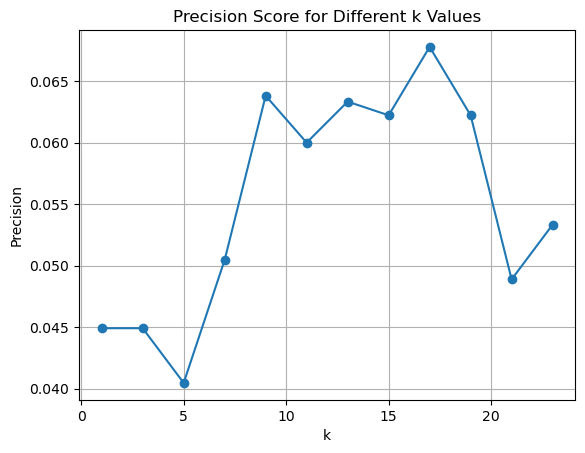

In [50]:
# tried different values here, see ui

with mlflow.start_run(run_name="k_opti_small_values", experiment_id=experiment_id) as parent:
    precision = []
    k_values = list(range(1, 25, 2))

    for k in k_values:
        with mlflow.start_run(run_name=f'child_{k}', nested=True) as child:
            print(f'RUN ID child_{k}:', child.info.run_id)

            parameters = {
                "preprocessing": 'bow',
                "feature": 'title_nltk',
                "k neighbors": k,
                "target": 'all_tags',
                "nb_tags_predicted": 5
            }
            mlflow.log_params(parameters)

            jaccard_moyen = predict_tags_using_knn(k=k, scorer=jaccard_score)

            metrics = {
                "jaccard": jaccard_moyen
            }
            # multiple metrics
            mlflow.log_metrics(metrics)

            precision.append((k, jaccard_moyen))

    jaccard_moyen = [item[1] for item in precision]

    # Plot precision scores against k values
    plt.plot(k_values, jaccard_moyen, marker='o')
    plt.xlabel('k')
    plt.ylabel('Precision')
    plt.title('Precision Score for Different k Values')
    plt.grid(True)

    # Save the plot
    plt.savefig("./artifacts/jaccard_plot_1_25.png")
    # Log the saved figure using MLflow
    mlflow.log_artifact("./artifacts/jaccard_plot_1_25.png")

    # Show the plot (optional)
    plt.show()


# k=13


### 2.9 Influence du nb de topics prédits sur la précision


RUN ID child_3: 070b14ab94ff4823a5b7b1e70128033a
doc 0 : ['create', 'gui', 'eclipse', 'java']
real tags : ['java', 'swing', 'user-interface', 'swt', 'awt']
predicted : ['c++', 'java', 'c']
0.3333333333333333 

doc 1 : ['mock', 'aws', 'sqs', 'call', 'unit', 'testing']
real tags : ['javascript', 'node.js', 'unit-testing', 'jestjs', 'aws-sdk']
predicted : ['c++', 'c#', 'c']
0.0 

doc 2 : ['add', 'image', 'splash', 'screen']
real tags : ['android', 'android-studio', 'imageview', 'gif', 'splash-screen']
predicted : ['c++', 'python', 'c']
0.0 

doc 3 : ['aws', 'import', 'module', 'module', 'name', 'request']
real tags : ['python', 'amazon-web-services', 'logging', 'aws-lambda', 'amazon-cloudwatch']
predicted : ['javascript', 'jestjs', 'babel-jest']
0.0 

doc 4 : ['ajax', 'request', 'vanilla', 'javascript']
real tags : ['javascript', 'jquery', 'ajax', 'api', 'ecmascript-6']
predicted : ['c++', 'c#', 'c']
0.0 

doc 5 : ['create', 'text', 'search', 'index', 'sqlalchemy', 'postgresql']
real tags

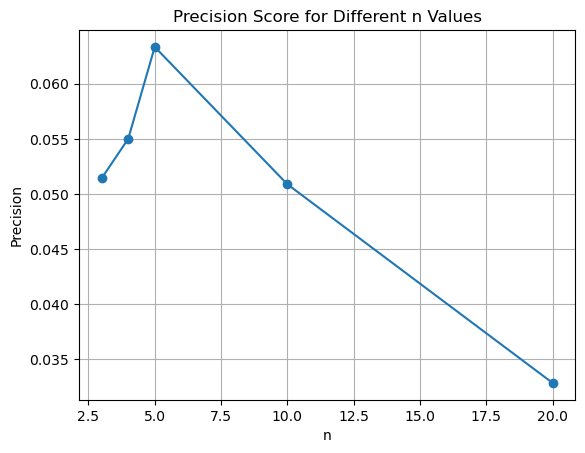

In [51]:
with mlflow.start_run(run_name="tags_opti", experiment_id=experiment_id) as parent:
    precision = []
    nb_tags = [3, 4, 5, 10, 20]

    for n in nb_tags:
        with mlflow.start_run(run_name=f'child_{n}', nested=True) as child:
            print(f'RUN ID child_{n}:', child.info.run_id)

            parameters = {
                "preprocessing": 'bow',
                "feature": 'title_nltk',
                "k neighbors": 13,
                "target": 'all_tags',
                "nb_tags_predicted": n
            }
            mlflow.log_params(parameters)

            jaccard_moyen = predict_tags_using_knn(k=13, n=n, scorer=jaccard_score)

            metrics = {
                "jaccard": jaccard_moyen
            }

            # multiple metrics
            mlflow.log_metrics(metrics)

            precision.append((n, jaccard_moyen))

    jaccard_moyen = [item[1] for item in precision]

    # Plot precision scores against k values
    plt.plot(nb_tags, jaccard_moyen, marker='o')
    plt.xlabel('n')
    plt.ylabel('Precision')
    plt.title('Precision Score for Different n Values')
    plt.grid(True)

    # Save the plot
    plt.savefig("./artifacts/jaccard_plot_3_4_tags.png")
    # Log the saved figure using MLflow
    mlflow.log_artifact("./artifacts/jaccard_plot_3_4_tags.png")

    # Show the plot (optional)
    plt.show()



### 2.10 Preprocessing (feature et target)


In [52]:
# Nous avons besoin de transformer la target pdt le preprocessing (-> bow)
# mm si on ne s'sn sert pas vraiment, car grid_search.fit() n'accepte que des valeurs numériques.

# Avantage : on peut utiliser des metriques classiques pour le score (ici r2),
# mais ca n'a aucun sens metier interpretable.
# peut tjs etre utile si fortement correlé à notre precision score custom
# ou au score de similarité Jaccard

# Compliqué à faire dans le pipeline sckikit, qui transforme les features mais pas la target.
# TransformedTargetRegressor ne convient pas non plus ici : c'est un modele wrapper,
# utilisé apres le pipeline.
# trouvé qq "solutions" + ou - elegantes, mais rien de compatible à la fois avec sklearn et mlflow.

# Ici convertir les tags en bag of words ou les one hot encoder revient exactement au meme, donc
# autant utiliser le bow, on a deja le transformeur.
# En + avec la plupart des embedding on peut considerer que la prediction de topics devient
# un probleme de regression, les valeurs predites par les modeles sont des vecteurs
# dans un espace techniquement fini, mais immense.


In [53]:
def token_list_into_bow(X):
    documents = X.tolist()
    # print(documents)
    gensim_dictionary = Dictionary(documents)
    corpus = [gensim_dictionary.doc2bow(doc) for doc in documents]

    # Convert Gensim corpus to dense matrix
    bow_matrix = corpus2dense(corpus, num_terms=len(gensim_dictionary)).T

    return bow_matrix, gensim_dictionary



### 2.11 (tentative de) gridsearch


In [54]:
# Prend trop de ressources !
# les runs mlflow sont + pratiques pour encapsuler le code

# En plus je me demande si la gridsearch est une bonne idée pour le knn.
# deja pour la lda et la nmf j'avais des doutes
# a verifier mais pour ces modeles je pense qu'un dataset d'entrainement plus petit peut
# serieusement impacter le nb optimal pour l'hyperparam
# (voisins pour le knn, topics pour lda et nmf)

def pipe_knn(train_df=train_df, feature='title_nltk', target='all_tags', test_df=test_df, metric='cosine'):
    # Load your training data and labels
    X_train = train_df[feature].values
    y_train = train_df[target].values

    X_bow_matrix, _ = token_list_into_bow(X_train)
    y_bow_matrix, _ = token_list_into_bow(y_train)

    # Create a KNN Regressor
    knn_regressor = KNeighborsRegressor(metric=metric)

    # Create a pipeline with preprocessing and a knn regressor, to simplify gridsearch
    pipe = Pipeline(steps=[
        ("knn_regressor", knn_regressor)
    ])

    # Define hyperparameters and their possible values for grid search
    param_grid = {
        'knn_regressor__n_neighbors': [11, 13, 15],
        'knn_regressor__weights': ['uniform'] # , 'distance'
    }

    # Create the GridSearchCV object with multiple scoring metrics
    # scoring = {'neg_mean_squared_error': 'neg_mean_squared_error', 'r2': 'r2'}
    grid_search = GridSearchCV(pipe, param_grid=param_grid,
                            scoring='r2', cv=3, verbose=1) # add, refit='precision' for multiple scoring

    # Fit the GridSearchCV object to your training data to perform hyperparameter tuning
    grid_search.fit(X_bow_matrix, y_bow_matrix)

    # Access the best hyperparameters
    best_params = grid_search.best_params_
    print("Best Hyperparameters:", best_params)

    # Create the KNN regressor with the best hyperparameters
    best_knn_regressor = KNeighborsRegressor(# metric=metric,
                                             n_neighbors=best_params['knn_regressor__n_neighbors'],
                                             weights=best_params['knn_regressor__weights'])

    # Create a pipeline with the preprocessor and the tuned knn regressor
    pipeline_with_tuned_knn = Pipeline(steps=[
        ("knn_regressor", best_knn_regressor)  # Use the tuned neighbor and weight values here
    ])

    # Perform cross-validation (on training set) and display the scores for each split
    # scoring = ['r2', 'neg_mean_squared_error']
    cv_scores = cross_validate(pipeline_with_tuned_knn, X_bow_matrix, y_bow_matrix, cv=5, scoring='r2')
    # print("Cross-Validation Scores (training):", '\n', cv_scores)
    print("Cross-Validation Scores:")
    pprint(cv_scores)
    for i, score in enumerate(cv_scores['test_score']):
        print(f"Split {i+1} : precision = {score}")


# crash le kernel
# pipe_knn()


In [55]:
# On oublie la gridsearchcv, mais on garde le scorer
# pour evaluer notre modele sur tt le training / testing set
# (pas seulement les 25 premieres lignes du set)

def pipe_knn(train_df=train_df, feature='title_nltk', target='all_tags', test_df=test_df, metric='cosine'):
    # Load your training data and labels
    X_train = train_df[feature].values
    y_train = train_df[target].values

    X_bow_matrix, _ = token_list_into_bow(X_train)
    y_bow_matrix, _ = token_list_into_bow(y_train)

    # Create a KNN Regressor
    knn_regressor = KNeighborsRegressor(metric=metric)

    # Define hyperparameters and their possible values for tuning
    params = {
        'n_neighbors': 13,
        'weights': 'uniform'
    }

    # Create the KNN regressor with the specified hyperparameters
    knn_regressor.set_params(**params)

    # Fit the KNN regressor to your training data
    knn_regressor.fit(X_bow_matrix, y_bow_matrix)

    # Evaluate the model using a scorer
    scorer = make_scorer(r2_score)
    score = scorer(knn_regressor, X_bow_matrix, y_bow_matrix)
    print("R2 Score:", score)

    return knn_regressor


# Demande bcp trop de ressources (31.5 GiB pour y_pred)
# pipe_knn()


### 2.12 Utilisation d'un classifier multilabel


In [56]:
# Utiliser un regresseur permet de facilement travailler avec l'ensemble des tags, mais
# nécessite une méthode .predict() custom, et les prédictions sont très lentes :
# impossible d'évaluer notre moèle sur une partie importante du dataset,
# on doit se contenter d'un petit sample.

# Voyons si un regresseur multilabel peut résoudre ces 2 problèmes


In [57]:
#

all_tags = [tag for tags in raw_data['all_tags'] for tag in tags]
print(f'Il y a {len(all_tags)} tags au total. \n')
print(f'Il y a {len(set(all_tags))} tags différents. \n')

# display(questions_tags)

# Fréquence
tag_frequencies_dict = {}
for tag in all_tags:
    tag_frequencies_dict[tag] = tag_frequencies_dict.get(tag, 0) + 1

# Sort the dictionary items by values in descending order
sorted_tag_frequencies = dict(sorted(tag_frequencies_dict.items(), key=lambda item: item[1], reverse=True))

# Extract tags and frequencies
tags = list(sorted_tag_frequencies.keys())
frequencies = list(sorted_tag_frequencies.values())

df_freq = pd.DataFrame({'Tag': tags, 'Frequency': frequencies})


Il y a 238327 tags au total. 

Il y a 15817 tags différents. 



In [58]:
def keep_most_frequent_tags(list_tags, df_freq=df_freq, lim=100):
    """
    Keep only the n most frequent tags (default 100).

    Parameters:
    - liste_tokens (list): The input list of tokens to be processed.
    - forbidden_list (set): A set of forbidden tokens, which includes stop words,
      tokens exceeding upper frequency limits, and tokens falling below lower frequency limits.

    Returns:
    list: A filtered list of tokens that excludes stop words, tokens exceeding upper frequency limits,
    and tokens falling below lower frequency limits.
    """

    mandatory_list = df_freq['Tag'][:lim].tolist()
    filtered_list = [token for token in list_tags if token in mandatory_list]

    return filtered_list


raw_data['top_tags_100'] = raw_data['all_tags'].apply(
    lambda x: keep_most_frequent_tags(x)
)

 # info targets vides
print(f'nb de targets desormais vides : {raw_data.loc[raw_data["top_tags_100"].apply(len) == 0, :].shape[0]} \
       (/ 50 000)', '\n')

display(raw_data.head())


nb de targets desormais vides : 2410        (/ 50 000) 



,CreationDate,title,body,all_tags,title_nltk,body_nltk,title_spacy,body_spacy,top_tags_100
0,2023-10-02 11:07:45,ImportError: cannot import name 'url_decode' f...,I am building a webapp using Flask. I imported...,"[python, flask, importerror, flask-login, werk...","[importerror, import, name, url]","[importerror, import, name, build, webapp, fla...","[importerror, import]","[build, webapp, import, flask, login, library,...",[python]
1,2023-09-25 09:05:11,Compilation error after upgrading to JDK 21 - ...,"After upgrading to JDK 21, I have the followin...","[spring-boot, compiler-errors, upgrade, lombok...","[compilation, error, upgrade, jdk, member, field]","[compilation, error, upgrade, jdk, member, fie...","[compilation, error, upgrade, member, field]","[upgrade, follow, compilation, error, project,...",[spring-boot]
2,2023-08-28 07:22:32,Differences between Langchain & LlamaIndex,I'm currently working on developing a chatbot ...,"[chatbot, openai-api, langchain, large-languag...",[difference],"[difference, work, develop, power, language, m...",[difference],"[work, develop, power, want, provide, response...",[]
3,2023-08-15 22:21:03,session not created: This version of ChromeDri...,I am running a Docker image from a Docker cont...,"[python, amazon-web-services, docker, google-c...","[session, create, version, chromedriver, suppo...","[session, create, version, chromedriver, suppo...","[session, create, version, support, version]","[run, image, container, environment, work, tod...","[python, amazon-web-services, docker, google-c..."
4,2023-08-01 08:16:21,Spring security method cannot decide pattern i...,When I try to run an application it fails to s...,"[java, spring-boot, eclipse, spring-security, ...","[spring, security, method, decide, pattern, bo...","[spring, security, method, decide, pattern, bo...","[spring, security, method, decide, pattern, ap...","[try, run, application, fail, start, throw, ex...","[java, spring-boot, eclipse]"


In [59]:
# MultiLabelBinarizer: Does not handle missing values directly. Missing values need to be handled
# before applying the transformation.
# not so sure about that

print(raw_data.shape)

data_100 = raw_data.loc[raw_data["top_tags_100"].apply(len) >= 0, :].copy()

print(data_100.shape, '\n')

display(data_100.head())


(47665, 9)
(47665, 9) 



,CreationDate,title,body,all_tags,title_nltk,body_nltk,title_spacy,body_spacy,top_tags_100
0,2023-10-02 11:07:45,ImportError: cannot import name 'url_decode' f...,I am building a webapp using Flask. I imported...,"[python, flask, importerror, flask-login, werk...","[importerror, import, name, url]","[importerror, import, name, build, webapp, fla...","[importerror, import]","[build, webapp, import, flask, login, library,...",[python]
1,2023-09-25 09:05:11,Compilation error after upgrading to JDK 21 - ...,"After upgrading to JDK 21, I have the followin...","[spring-boot, compiler-errors, upgrade, lombok...","[compilation, error, upgrade, jdk, member, field]","[compilation, error, upgrade, jdk, member, fie...","[compilation, error, upgrade, member, field]","[upgrade, follow, compilation, error, project,...",[spring-boot]
2,2023-08-28 07:22:32,Differences between Langchain & LlamaIndex,I'm currently working on developing a chatbot ...,"[chatbot, openai-api, langchain, large-languag...",[difference],"[difference, work, develop, power, language, m...",[difference],"[work, develop, power, want, provide, response...",[]
3,2023-08-15 22:21:03,session not created: This version of ChromeDri...,I am running a Docker image from a Docker cont...,"[python, amazon-web-services, docker, google-c...","[session, create, version, chromedriver, suppo...","[session, create, version, chromedriver, suppo...","[session, create, version, support, version]","[run, image, container, environment, work, tod...","[python, amazon-web-services, docker, google-c..."
4,2023-08-01 08:16:21,Spring security method cannot decide pattern i...,When I try to run an application it fails to s...,"[java, spring-boot, eclipse, spring-security, ...","[spring, security, method, decide, pattern, bo...","[spring, security, method, decide, pattern, bo...","[spring, security, method, decide, pattern, ap...","[try, run, application, fail, start, throw, ex...","[java, spring-boot, eclipse]"


In [60]:
quick_df = data_100[::10]

train_df, test_df = train_test_split(quick_df, test_size=0.1, random_state=42)

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)


In [61]:
def knn_classifier(train_df=train_df, feature='title_nltk', k=13, target='top_tags_100', test_df=test_df):
    # Load your training data and labels
    X_train = train_df[feature].values
    y_train = train_df[target].tolist()

    # training set
    X_bow_matrix, dict = token_list_into_bow(X_train)

    # target encoding
    mlb = MultiLabelBinarizer()
    y_encoded = mlb.fit_transform(y_train)

    # Create a KNN classifier this time
    knn = KNeighborsClassifier()

    # Define hyperparameters and their possible values for tuning
    params = {
        'n_neighbors': k
    }

    # Create the KNN regressor with the specified hyperparameters
    knn.set_params(**params)

    # Fit the KNN regressor to your training data
    knn.fit(X_bow_matrix, y_encoded)

    # Evaluate the model using a scorer
    scorer = custom_jacc_scorer
    score = scorer(knn, X_bow_matrix, y_encoded)
    print("Score : ", score)

    return knn, mlb, dict


knn_100, mlb_100, dict_100 = knn_classifier()


Score :  0.5686480186480186


In [62]:
def create_top_n_tags_feature(raw_data=raw_data, n=100, slice=1):
    raw_data[f'top_tags_{n}'] = raw_data['all_tags'].apply(
        lambda x: keep_most_frequent_tags(x, lim=n)
    )

    data = raw_data.loc[raw_data[f'top_tags_{n}'].apply(len) >= 0, :].copy()
    print(data.shape, '\n')

    slice_df = data[::slice]
    # slice_df.reset_index(drop=True, inplace=True)

    # stratify ?
    train_df, test_df = train_test_split(slice_df, test_size=0.1, random_state=42)

    train_df.reset_index(drop=True, inplace=True)
    test_df.reset_index(drop=True, inplace=True)


    return train_df, test_df


train_df, test_df = create_top_n_tags_feature(n=50, slice=10)


(47665, 10) 



In [63]:
display(raw_data.head())


,CreationDate,title,body,all_tags,title_nltk,body_nltk,title_spacy,body_spacy,top_tags_100,top_tags_50
0,2023-10-02 11:07:45,ImportError: cannot import name 'url_decode' f...,I am building a webapp using Flask. I imported...,"[python, flask, importerror, flask-login, werk...","[importerror, import, name, url]","[importerror, import, name, build, webapp, fla...","[importerror, import]","[build, webapp, import, flask, login, library,...",[python],[python]
1,2023-09-25 09:05:11,Compilation error after upgrading to JDK 21 - ...,"After upgrading to JDK 21, I have the followin...","[spring-boot, compiler-errors, upgrade, lombok...","[compilation, error, upgrade, jdk, member, field]","[compilation, error, upgrade, jdk, member, fie...","[compilation, error, upgrade, member, field]","[upgrade, follow, compilation, error, project,...",[spring-boot],[spring-boot]
2,2023-08-28 07:22:32,Differences between Langchain & LlamaIndex,I'm currently working on developing a chatbot ...,"[chatbot, openai-api, langchain, large-languag...",[difference],"[difference, work, develop, power, language, m...",[difference],"[work, develop, power, want, provide, response...",[],[]
3,2023-08-15 22:21:03,session not created: This version of ChromeDri...,I am running a Docker image from a Docker cont...,"[python, amazon-web-services, docker, google-c...","[session, create, version, chromedriver, suppo...","[session, create, version, chromedriver, suppo...","[session, create, version, support, version]","[run, image, container, environment, work, tod...","[python, amazon-web-services, docker, google-c...","[python, amazon-web-services, docker]"
4,2023-08-01 08:16:21,Spring security method cannot decide pattern i...,When I try to run an application it fails to s...,"[java, spring-boot, eclipse, spring-security, ...","[spring, security, method, decide, pattern, bo...","[spring, security, method, decide, pattern, bo...","[spring, security, method, decide, pattern, ap...","[try, run, application, fail, start, throw, ex...","[java, spring-boot, eclipse]","[java, spring-boot]"


In [64]:
knn_50, mlb_50, dict_50 = knn_classifier(train_df=train_df, k=5, target='top_tags_50')


Score :  0.6874125874125874


In [65]:
def string_query_into_bow_vector(query, dictionary):
    query_token_list = preprocess_text(query)
    query_bow = dictionary.doc2bow(query_token_list)
    query_vector = corpus2dense([query_bow], num_terms=len(dictionary)).T


    return query_vector



### 2.13 predict


In [66]:
# predict

def predict_tags(test_data, model=knn_50, mlb_encoder=mlb_50, dictionary=dict_50):
    # Transform test features
    query = string_query_into_bow_vector(test_data, dictionary)

    # Make predictions
    predicted_labels = model.predict(query)

    # Inverse transform predicted labels
    predicted_tags = mlb_encoder.inverse_transform(predicted_labels)

    return predicted_tags


def test_prediction(index=0):
    predicted_tags = predict_tags(test_df['title'][index])
    print(test_df['all_tags'][index])
    print(test_df['top_tags_50'][index])
    print(predicted_tags, '\n')


test_prediction()


['php', 'laravel-5', 'oauth', 'permissions', 'laravel-passport']
['php']
[()] 



/tmp/ipykernel_37378/2421486217.py:62: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


In [67]:
test_prediction(1)
test_prediction(2)
test_prediction(3)
test_prediction(4)
test_prediction(5)
test_prediction(6)

# bcp de "predictions" nulles


/tmp/ipykernel_37378/2421486217.py:62: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


['python', 'selenium', 'browser', 'selenium-webdriver', 'incognito-mode']
['python']
[('python',)] 

['spring', 'mongodb', 'spring-data', 'spring-data-mongodb', 'hibernate-ogm']
['spring']
[()] 



['c#', '.net', 'mapping', 'automapper', 'automapper-2']
['c#', '.net']
[()] 

['python', 'multidimensional-array', 'deep-learning', 'pytorch', 'tensor']
['python']
[()] 

['php', 'apache', 'curl', 'wamp', 'kohana']
['php']
[()] 

['linux', 'audio', 'microphone', 'alsa', 'voice-recording']
['linux']
[()] 



### 2.14 vs predict_proba


In [68]:
def always_predict_tags(test_data, knn_model=knn_50, mlb_encoder=mlb_50, dictionary=dict_50, top_n=5):
    # Transform test features
    query = string_query_into_bow_vector(test_data, dictionary)

    # Make predictions and get probabilities
    probabilities = knn_model.predict_proba(query)

    # Extract tags from the mlb_encoder
    tags = mlb_encoder.classes_

    # Create a dictionary to store results
    results = {}

    # Iterate over probabilities and tags
    for i, tag in enumerate(tags):
        # Extract the probability for the current tag
        probability = probabilities[i][0][0]
        # Store the probability with the tag as the key
        results[tag] = probability

    # Sort the dictionary items by values in descending order
    sorted_results = dict(sorted(results.items(), key=lambda item: item[1], reverse=True))
    predicted_tags = list(sorted_results)[:top_n]
    # Construct a list of tuples containing tags and their corresponding probabilities
    tags_with_probas = [(tag, sorted_results[tag]) for tag in predicted_tags]

    return tags_with_probas


def test_prediction(index=0):
    predicted_tags = always_predict_tags(test_df['title'][index])
    print(test_df['all_tags'][index])
    print(test_df['top_tags_50'][index])
    print(predicted_tags, '\n')


test_prediction()

# bcp de probas == 1 alors qu'on n'avait pas de prediction (ou 1) sur cet exemple ??


['php', 'laravel-5', 'oauth', 'permissions', 'laravel-passport']
['php']
[('.net', 1.0), ('android', 1.0), ('angular', 1.0), ('angularjs', 1.0), ('arrays', 1.0)] 



/tmp/ipykernel_37378/2421486217.py:62: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


In [69]:
test_prediction(1)
test_prediction(2)
test_prediction(3)
test_prediction(4)
test_prediction(5)
test_prediction(6)

# bcp trop de valeurs à 1
# pour le knn on peut tjs utiliser notre predict custom, mais pour les autres modeles
# il faudra une difference plus nette.


/tmp/ipykernel_37378/2421486217.py:62: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


['python', 'selenium', 'browser', 'selenium-webdriver', 'incognito-mode']
['python']
[('.net', 1.0), ('android', 1.0), ('angular', 1.0), ('angularjs', 1.0), ('arrays', 1.0)] 

['spring', 'mongodb', 'spring-data', 'spring-data-mongodb', 'hibernate-ogm']
['spring']
[('.net', 1.0), ('amazon-web-services', 1.0), ('android', 1.0), ('angular', 1.0), ('angularjs', 1.0)] 

['c#', '.net', 'mapping', 'automapper', 'automapper-2']
['c#', '.net']
[('.net', 1.0), ('amazon-web-services', 1.0), ('android', 1.0), ('angular', 1.0), ('angularjs', 1.0)] 

['python', 'multidimensional-array', 'deep-learning', 'pytorch', 'tensor']
['python']
[('.net', 1.0), ('amazon-web-services', 1.0), ('android', 1.0), ('angular', 1.0), ('angularjs', 1.0)] 

['php', 'apache', 'curl', 'wamp', 'kohana']
['php']
[('.net', 1.0), ('angularjs', 1.0), ('arrays', 1.0), ('asp.net', 1.0), ('asp.net-mvc', 1.0)] 

['linux', 'audio', 'microphone', 'alsa', 'voice-recording']
['linux']
[('amazon-web-services', 1.0), ('android', 1.0), (

## 3 Autres classifieur multilabels


### 3.1 Logistic regression


In [70]:
train_df, test_df = create_top_n_tags_feature(n=50, slice=50)


(47665, 10) 



In [71]:
_, standard_dict_title = token_list_into_bow(train_df['title_nltk'])


def token_list_into_bow_using_specific_dict(X, dict=standard_dict_title):
    documents = X.tolist()
    # print(documents)
    gensim_dictionary = dict
    corpus = [gensim_dictionary.doc2bow(doc) for doc in documents]

    # Convert Gensim corpus to dense matrix
    bow_matrix = corpus2dense(corpus, num_terms=len(gensim_dictionary)).T

    return bow_matrix


In [72]:
# pas nativement mutilabel -> approche one vs rest via MultiOutputClassifier()

def logistic_regression_classifier(train_df=train_df, feature='title_nltk', dict=standard_dict_title,
                                   target='top_tags_50', test_df=test_df):

    # Load your training data and labels
    X_train = train_df[feature].values
    y_train = train_df[target].tolist()

    # training set
    X_bow_matrix = token_list_into_bow_using_specific_dict(X_train, dict)

    # target encoding
    mlb = MultiLabelBinarizer()
    y_encoded = mlb.fit_transform(y_train)

    # Create a Logistic Regression classifier
    logistic_reg = LogisticRegression(random_state=42)

    # Create a MultiOutputClassifier with the Logistic Regression classifier
    multi_output_classifier = MultiOutputClassifier(logistic_reg)

    # Fit the MultiOutputClassifier to your training data
    multi_output_classifier.fit(X_bow_matrix, y_encoded)

    # Evaluate the model using a scorer
    scorer = custom_jacc_scorer
    score = scorer(multi_output_classifier, X_bow_matrix, y_encoded)
    print("Score : ", score)


    return multi_output_classifier, mlb


multi_output_classifier, mlb_50 = logistic_regression_classifier()


Score :  0.8091852197225784


In [73]:
# predict

def test_prediction(index=0):
    predicted_tags = predict_tags(test_df['title'][index], multi_output_classifier, mlb_50, standard_dict_title)
    print(test_df['all_tags'][index])
    print(test_df['top_tags_50'][index])
    print(predicted_tags, '\n')


test_prediction()


['python', 'json', 'pandas', 'dataframe', 'pretty-print']
['python', 'json', 'pandas', 'dataframe']
[('json',)] 



In [74]:
for i in range(1,7):
    test_prediction(i)


['c#', '.net', 'wcf', 'service', '.net-core']
['c#', '.net']
[('c#',)] 



['asp.net', '.net', 'iis', 'iis-7.5', 'microsoft-web-deploy']
['asp.net', '.net']
[('java',)] 

['css', 'input', 'autocomplete', 'font-size', 'tailwind-css']
['css']
[()] 

['c#', 'wcf', 'wcf-security', 'wcf-binding', 'wcf-client']
['c#']
[()] 

['c#', 'linq', 'using', 'datareader', 'yield-return']
['c#']
[()] 

['javascript', 'html', 'node.js', 'express', 'nodemailer']
['javascript', 'html', 'node.js']
[('html',)] 



In [75]:
# predict proba

def test_prediction(index=0):
    predicted_tags = always_predict_tags(test_df['title'][index], multi_output_classifier, mlb_50, standard_dict_title)
    print(test_df['all_tags'][index])
    print(test_df['top_tags_50'][index])
    print(predicted_tags, '\n')


for i in range(0,7):
    test_prediction(i)


['python', 'json', 'pandas', 'dataframe', 'pretty-print']
['python', 'json', 'pandas', 'dataframe']
[('database', 0.9989123696444507), ('ruby-on-rails', 0.9986742929073462), ('windows', 0.9986105724762163), ('sql-server', 0.9985587591543433), ('angularjs', 0.9984206188500138)] 

['c#', '.net', 'wcf', 'service', '.net-core']
['c#', '.net']
[('django', 0.9972572853328221), ('ruby-on-rails', 0.9971488262005412), ('postgresql', 0.9971322412032406), ('typescript', 0.9970719440595849), ('reactjs', 0.9970616028385292)] 

['asp.net', '.net', 'iis', 'iis-7.5', 'microsoft-web-deploy']
['asp.net', '.net']
[('dataframe', 0.9987905200016867), ('arrays', 0.9985192267932762), ('bash', 0.9982100820920691), ('pandas', 0.9979282689747422), ('string', 0.9978057599235375)] 

['css', 'input', 'autocomplete', 'font-size', 'tailwind-css']
['css']
[('dataframe', 0.9984655088761695), ('docker', 0.9970508889619799), ('bash', 0.9964082024011353), ('arrays', 0.9963196909746237), ('pandas', 0.9962426437829432)] 



### 3.2 SGDClassifier


In [76]:
# using default SVM

def sgd_classifier(train_df=train_df, feature='title_nltk', target='top_tags_50',
                   dict=standard_dict_title, test_df=test_df):

    # Load your training data and labels
    X_train = train_df[feature].values
    y_train = train_df[target].tolist()

    # Training set
    X_bow_matrix = token_list_into_bow_using_specific_dict(X_train, dict)

    # Target encoding
    mlb = MultiLabelBinarizer()
    y_encoded = mlb.fit_transform(y_train)

    # Create an SGDClassifier with default parameters
    sgd_clf = SGDClassifier(random_state=42)  # default loss='hinge', gives a linear SVM

    # Create a MultiOutputClassifier with the SGD classifier
    multi_output_classifier = MultiOutputClassifier(sgd_clf)

    # Fit the MultiOutputClassifier to your training data
    multi_output_classifier.fit(X_bow_matrix, y_encoded)

    # Evaluate the model using a scorer
    scorer = custom_jacc_scorer
    score = scorer(multi_output_classifier, X_bow_matrix, y_encoded)
    print("Score : ", score)

    return multi_output_classifier, mlb


multi_output_classifier_svm, mlb_50 = sgd_classifier()

# tres bon score, bcp + rapide


Score :  0.9125189416015853


In [77]:
# predict (best score)

def test_prediction(index=0):
    predicted_tags = predict_tags(test_df['title'][index], multi_output_classifier_svm, mlb_50, standard_dict_title)
    print(test_df['all_tags'][index])
    print(test_df['top_tags_50'][index])
    print(predicted_tags, '\n')


for i in range(0,7):
    test_prediction(i)


['python', 'json', 'pandas', 'dataframe', 'pretty-print']
['python', 'json', 'pandas', 'dataframe']
[('json', 'pandas', 'python')] 

['c#', '.net', 'wcf', 'service', '.net-core']
['c#', '.net']
[('c#',)] 

['asp.net', '.net', 'iis', 'iis-7.5', 'microsoft-web-deploy']
['asp.net', '.net']
[('java',)] 

['css', 'input', 'autocomplete', 'font-size', 'tailwind-css']
['css']
[()] 

['c#', 'wcf', 'wcf-security', 'wcf-binding', 'wcf-client']
['c#']
[()] 

['c#', 'linq', 'using', 'datareader', 'yield-return']
['c#']
[('python',)] 

['javascript', 'html', 'node.js', 'express', 'nodemailer']
['javascript', 'html', 'node.js']
[('html',)] 



In [78]:
# predict proba

def test_prediction(index=0):
    predicted_tags = always_predict_tags(test_df['title'][index], multi_output_classifier_svm, mlb_50, standard_dict_title)
    print(test_df['all_tags'][index])
    print(test_df['top_tags_50'][index])
    print(predicted_tags, '\n')


# test_prediction(0)

# Ne fonctionne pas, la SVM ne possède pas la méthode predict_proba


In [79]:
# using logistic reg

def sgd_classifier(train_df=train_df, feature='title_nltk', target='top_tags_50',
                   dict=standard_dict_title, test_df=test_df):

    # Load your training data and labels
    X_train = train_df[feature].values
    y_train = train_df[target].tolist()

    # Training set
    X_bow_matrix = token_list_into_bow_using_specific_dict(X_train, dict)

    # Target encoding
    mlb = MultiLabelBinarizer()
    y_encoded = mlb.fit_transform(y_train)

    # Create an SGDClassifier with default parameters
    sgd_clf = SGDClassifier(random_state=42, loss='log_loss')  # for logistic regression

    # Create a MultiOutputClassifier with the SGD classifier
    multi_output_classifier = MultiOutputClassifier(sgd_clf)

    # Fit the MultiOutputClassifier to your training data
    multi_output_classifier.fit(X_bow_matrix, y_encoded)

    # Evaluate the model using a scorer
    scorer = custom_jacc_scorer
    score = scorer(multi_output_classifier, X_bow_matrix, y_encoded)
    print("Score : ", score)

    return multi_output_classifier, mlb

multi_output_classifier, mlb_50 = sgd_classifier()


Score :  0.8280102576057815


### 3.3 Random forest


In [80]:
# train_df, test_df = create_top_n_tags_feature(n=50, slice=50)


In [81]:
def random_forest_classifier(train_df=train_df, feature='title_nltk', target='top_tags_50',
                             dict=standard_dict_title, test_df=test_df):

    # Load your training data and labels
    X_train = train_df[feature].values
    y_train = train_df[target].tolist()

    # Training set
    X_bow_matrix = token_list_into_bow_using_specific_dict(X_train, dict)

    # Target encoding
    mlb = MultiLabelBinarizer()
    y_encoded = mlb.fit_transform(y_train)

    # Create a Random Forest Classifier with default parameters
    rf_clf = RandomForestClassifier(random_state=42)

    # Create a MultiOutputClassifier with the Random Forest Classifier
    multi_output_classifier = MultiOutputClassifier(rf_clf)

    # Fit the MultiOutputClassifier to your training data
    multi_output_classifier.fit(X_bow_matrix, y_encoded)

    # Evaluate the model using a scorer
    scorer = custom_jacc_scorer
    score = scorer(multi_output_classifier, X_bow_matrix, y_encoded)
    print("Score : ", score)

    return multi_output_classifier, mlb


multi_output_classifier_rf, mlb_50_rf = random_forest_classifier()

# + lent
# score wow


Score :  0.9984846718731787


In [82]:
# predict

def test_prediction(index=0):
    predicted_tags = predict_tags(test_df['title'][index], multi_output_classifier_rf, mlb_50_rf, standard_dict_title)
    print(test_df['all_tags'][index])
    print(test_df['top_tags_50'][index])
    print(predicted_tags, '\n')


for i in range(0,7):
    test_prediction(i)


['python', 'json', 'pandas', 'dataframe', 'pretty-print']
['python', 'json', 'pandas', 'dataframe']
[('json', 'python')] 

['c#', '.net', 'wcf', 'service', '.net-core']
['c#', '.net']
[('c#',)] 

['asp.net', '.net', 'iis', 'iis-7.5', 'microsoft-web-deploy']
['asp.net', '.net']
[()] 

['css', 'input', 'autocomplete', 'font-size', 'tailwind-css']
['css']
[()] 

['c#', 'wcf', 'wcf-security', 'wcf-binding', 'wcf-client']
['c#']
[()] 

['c#', 'linq', 'using', 'datareader', 'yield-return']
['c#']
[()] 

['javascript', 'html', 'node.js', 'express', 'nodemailer']
['javascript', 'html', 'node.js']
[('html',)] 



In [83]:
# predict proba

def test_prediction(index=0):
    predicted_tags = always_predict_tags(test_df['title'][index], multi_output_classifier_rf, mlb_50_rf, standard_dict_title)
    print(test_df['all_tags'][index])
    print(test_df['top_tags_50'][index])
    print(predicted_tags, '\n')


for i in range(0,7):
    test_prediction(i)


['python', 'json', 'pandas', 'dataframe', 'pretty-print']
['python', 'json', 'pandas', 'dataframe']
[('angular', 1.0), ('angularjs', 1.0), ('arrays', 1.0), ('asp.net', 1.0), ('asp.net-mvc', 1.0)] 

['c#', '.net', 'wcf', 'service', '.net-core']
['c#', '.net']
[('amazon-web-services', 1.0), ('android', 1.0), ('angular', 1.0), ('angularjs', 1.0), ('bash', 1.0)] 

['asp.net', '.net', 'iis', 'iis-7.5', 'microsoft-web-deploy']
['asp.net', '.net']
[('.net', 1.0), ('angularjs', 1.0), ('arrays', 1.0), ('bash', 1.0), ('c', 1.0)] 

['css', 'input', 'autocomplete', 'font-size', 'tailwind-css']
['css']
[('.net', 1.0), ('amazon-web-services', 1.0), ('angular', 1.0), ('angularjs', 1.0), ('arrays', 1.0)] 

['c#', 'wcf', 'wcf-security', 'wcf-binding', 'wcf-client']
['c#']
[('amazon-web-services', 1.0), ('arrays', 1.0), ('asp.net-mvc', 1.0), ('bash', 1.0), ('c', 1.0)] 

['c#', 'linq', 'using', 'datareader', 'yield-return']
['c#']
[('angularjs', 1.0), ('asp.net', 1.0), ('bash', 1.0), ('css', 1.0), ('dock

## 4 Drift


In [84]:
raw_data['CreationDate'] = pd.to_datetime(raw_data['CreationDate'])

raw_data['year_month'] = raw_data['CreationDate'].map(lambda dt: dt.strftime('%Y-%m'))

print(raw_data['year_month'].min())
print(raw_data['year_month'].max())


2011-05
2023-10


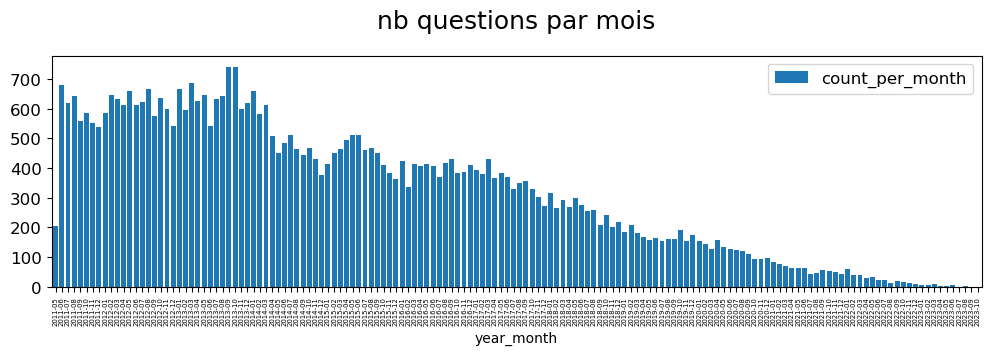

In [85]:
grouped_month = raw_data.groupby('year_month').size().to_frame("count_per_month").reset_index()

fig, ax = plt.subplots(figsize=(12, 3))  # Adjust the figsize as needed

grouped_month.plot(kind='bar', x='year_month', y='count_per_month', fontsize=12, ax=ax, width=0.8)
plt.title('nb questions par mois', fontsize=18, pad=20)
plt.legend(loc='upper right', fontsize=12)
plt.xticks(fontsize=5)
plt.show()


In [86]:
# Concernant l’analyse de la stabilité du modèle, il est attendu de prendre un dataset par mois de questions
# sur un an, et de mesurer l’évolution des mesures et scores du modèle défini, afin d’en conclure une
# stabilité ou pas d’un modèle de référence établi sur des questions antérieures à cette période.

# test rapide avec logistic reg

month = []

unique_values = np.sort(raw_data['year_month'].unique())
print(len(unique_values))
# print(unique_values)

for mois in unique_values[:13]:
    month.append(raw_data.loc[raw_data['year_month'] == mois, :].copy())

print(len(month))


150
13


In [87]:
display(month[1].head())


,CreationDate,title,body,all_tags,title_nltk,body_nltk,title_spacy,body_spacy,top_tags_100,top_tags_50,year_month
46779,2011-06-30 23:47:29,How to train an artificial neural network to p...,I'm currently trying to get an ANN to play a v...,"[machine-learning, computer-vision, neural-net...","[train, network, play, input]","[train, network, play, input, try, get, ann, p...","[train, network, play, input]","[try, play, video, game, hope, help, community...",[machine-learning],[],2011-06
46780,2011-06-30 23:08:02,Rails Admin vs. ActiveAdmin,I've been looking into some rails admin plugin...,"[ruby-on-rails, ruby, ruby-on-rails-3, activea...","[rail, admin]","[rail, admin, look, rail, admin, plugins, come...",[rail],"[look, rail, admin, plugin, come, add, suggest...","[ruby-on-rails, ruby]",[ruby-on-rails],2011-06
46781,2011-06-30 22:41:20,How to propagate PropertyChanged changes in De...,I have a class which implements INotifyPropert...,"[c#, wpf, xaml, data-binding, dependency-prope...","[propagate, propertychanged, change, dependenc...","[propagate, propertychanged, change, dependenc...","[propagate, change]","[class, implement, instance, class, declare, r...","[c#, wpf]",[c#],2011-06
46782,2011-06-30 21:27:39,thread messaging system database schema design,I'm trying to achieve exactly what's explained...,"[asp.net, database, linq, entity-framework, da...","[thread, message, system, database, schema, de...","[thread, message, system, database, schema, de...","[thread, message, system, database, design]","[try, achieve, explain, create, messaging, sys...","[asp.net, database, entity-framework]","[asp.net, database]",2011-06
46783,2011-06-30 21:09:11,Improve subplot size/spacing with many subplots,I need to generate a whole bunch of vertically...,"[python, pandas, matplotlib, seaborn, subplot]","[improve, subplot, size, space, subplots]","[improve, subplot, size, space, subplots, need...","[improve, subplot, size, space, subplot]","[need, generate, bunch, stack, plot, matplotli...","[python, pandas, matplotlib]","[python, pandas]",2011-06


In [88]:
display(month[12].head()) # last one


,CreationDate,title,body,all_tags,title_nltk,body_nltk,title_spacy,body_spacy,top_tags_100,top_tags_50,year_month
40141,2012-05-31 23:29:35,GUI MySQL database frontend,I have a slightly hopeless wish list for a pie...,"[php, mysql, database, user-interface, web-app...","[gui, mysql, database, frontend]","[gui, mysql, database, frontend, list, piece, ...","[mysql, database, frontend]","[wish, list, piece, software, know, exist, nee...","[php, mysql, database]","[php, mysql, database]",2012-05
40142,2012-05-31 21:50:23,JavaScript format number to day with always 3 ...,\nPossible Duplicate:\nHow can I create a Zero...,"[javascript, numbers, format, digits, days]","[javascript, format, number, day, digit]","[javascript, format, number, day, digit, dupli...","[format, number, day, digit]","[create, value, output, day, number, digit, wr...",[javascript],[javascript],2012-05
40143,2012-05-31 21:27:27,Canvas drawImage scaling,I'm trying to scale an image proportionately t...,"[javascript, canvas, html5-canvas, resize, dra...","[canvas, drawimage, scaling]","[canvas, drawimage, scale, try, scale, image, ...","[canvas, drawimage, scale]","[try, scale, image, canvas, scale, fix, width,...",[javascript],[javascript],2012-05
40144,2012-05-31 20:40:47,Render embedded image in PDF using Flying-Sauc...,I have an xhtml document that I'm turning into...,"[java, pdf-generation, embedded-resource, flyi...","[render, embed, image, pdf, fly, html]","[render, embed, image, pdf, fly, html, documen...","[embed, image, pdf, html]","[document, turn, pdf, tag, base64, encode, ima...",[java],[java],2012-05
40145,2012-05-31 18:41:21,Resize bitmap image,I want to have smaller size at image saved. \n...,"[c#, wpf, image, bitmap, resize]","[resize, bitmap, image]","[resize, image, want, size, image, save, resiz...","[resize, image]","[want, size, image, save, resize, use, code, i...","[c#, wpf, image]",[c#],2012-05


In [89]:
# add mlflow

logistic_reg, mlb = sgd_classifier(train_df=month[1])

for i in range(2, 13):
    train_df = month[i]
    X_train = train_df['title_nltk'].values
    y_train = train_df['top_tags_50'].tolist()

    # Training set
    X_bow_matrix = token_list_into_bow_using_specific_dict(X_train, standard_dict_title)

    # Target encoding
    y_encoded = mlb.fit_transform(y_train)

    score_next_month = custom_jacc_scorer(logistic_reg, X_bow_matrix, y_encoded)
    print(score_next_month)


# graph
# tester evidently AI ?


Score :  0.9963235294117647
0.7657512116316639
0.7701863354037267
0.7602862254025045
0.7640545144804088
0.7653985507246377
0.761595547309833
0.7589743589743589
0.7341576506955177
0.7563291139240507
0.7504078303425775
0.764750378214826


## NN Model


In [92]:
train_df, test_df = create_top_n_tags_feature(n=30, slice=2)


(47665, 12) 



In [93]:
train_df, val_df = train_test_split(train_df, train_size=0.9, random_state=1)

train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

display(train_df.head())


,CreationDate,title,body,all_tags,title_nltk,body_nltk,title_spacy,body_spacy,top_tags_100,top_tags_50,year_month,top_tags_30
0,2013-09-29 12:44:22,Python: How would you save a simple settings/c...,"I don't care if it's JSON, pickle, YAML, or wh...","[python, json, settings, config, ini]","[python, save, setting, config, file]","[python, save, setting, config, file, care, js...","[save, setting, file]","[care, json, pickle, implementation, config, f...","[python, json]","[python, json]",2013-09,"[python, json]"
1,2012-08-03 07:42:28,"My Routes are Returning a 404, How can I Fix T...",I've just started learning the Laravel framewo...,"[php, laravel, routes, laravel-routing, larave...","[route, return, fix]","[route, return, fix, start, learn, laravel, fr...","[return, fix]","[start, learn, framework, issue, routing, rout...","[php, laravel]","[php, laravel]",2012-08,[php]
2,2013-03-06 00:24:26,Should I use MapView or MapFragment,I am not sure whether I should be using MapVie...,"[android, google-maps, android-mapview, google...","[mapview, mapfragment]","[mapview, mapfragment, mapview, stick, mapfrag...",[use],"[stick, application, app, find, set, place, wa...",[android],[android],2013-03,[android]
3,2012-06-14 11:17:52,bootstrap scrollspy highlights last navigation...,I've built a navigation bar at the top with 5 ...,"[javascript, jquery, css, twitter-bootstrap, t...","[bootstrap, highlight, navigation, link, butto...","[bootstrap, highlight, navigation, link, butto...","[link, button, load]","[build, navigation, bar, link, page, add, sect...","[javascript, jquery, css, twitter-bootstrap]","[javascript, jquery, css]",2012-06,"[javascript, jquery, css]"
4,2018-10-12 02:23:10,How to insert a record with custom id use Spri...,"For Spring Data JPA, I can use @GeneratedValue...","[java, spring, insert, id-generation, spring-d...","[insert, record, custom, id, spring, data, jdbc]","[insert, record, custom, id, spring, data, jdb...","[insert, record, custom, use, data, jdbc]","[use, insert, record, custom, insert, record, ...","[java, spring]","[java, spring]",2018-10,"[java, spring]"


In [95]:
NB_TAGS = 30

feature = 'title_nltk' # on va testeer le tokenizer de keras
target = 'top_tags_' + str(NB_TAGS)

X_train = train_df[feature].values
y_train = train_df[target].tolist()

# Set up validation data.
X_val = val_df[feature].values
y_val = val_df[target].tolist()


# Into BOW
X_train = token_list_into_bow_using_specific_dict(X_train, dict=standard_dict_title)
X_val = token_list_into_bow_using_specific_dict(X_val, dict=standard_dict_title)


MAX_LEN = 15
X_train = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=MAX_LEN)


In [96]:
len(standard_dict_title)


3931

In [97]:
# encodage target

def target_encoding(y):
    # Target encoding
    mlb = MultiLabelBinarizer()
    y_encoded = mlb.fit_transform(y)

    return y_encoded


y_train_encoded = target_encoding(y_train)
y_val_encoded = target_encoding(y_val)

print(y_train_encoded)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 1]
 [0 0 0 ... 0 0 0]]


In [ ]:
# See what a keras forward 2-3 layers model can do with same simple bow encoding

# + 1 to account for padding token.
num_tokens = MAX_LEN + 1

embedding_layer = layers.Embedding(     # MODIFS HERE
    num_tokens,  #
    len(standard_dict_title),  # = DIM BOW
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    input_length=MAX_LEN,
    trainable=True
)




tf.random.set_seed(0)

model = keras.Sequential()

# This layer will output a sequence of 300-dimension *vectors*, one for each element in the input sequence.
model.add(embedding_layer)

# This layer will calculate an average of those vectors.
model.add(layers.GlobalAveragePooling1D())

model.add(layers.Dense(150, activation='relu', kernel_initializer=tf.keras.initializers.random_normal(seed=1)))
model.add(layers.Dense(75, activation='relu', kernel_initializer=tf.keras.initializers.random_normal(seed=1)))
model.add(layers.Dense(NB_TAGS, activation='sigmoid', kernel_initializer=tf.keras.initializers.random_normal(seed=1)))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])